# Analyse Bleu/Rouge ?

In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from sacrebleu import BLEU
from rouge import Rouge 
import matplotlib.pyplot as plt
import random
from reco_systems.evaluation import _hide_ratings_full_matrix
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from surprise import NMF, Dataset
from surprise.reader import Reader
import seaborn as sns

from reco_systems.CF_knn import calc_similarity_matrix, get_KNN
from random import choice

%load_ext autoreload
%autoreload 2

# Current version

In [8]:
# Construction de la BDD avec avis centrés
avis = pd.read_csv("../database_cleaned/avis_clean.csv", index_col = 0)
test2 = avis[avis['User id'] == 3069]
min_reviews = 20
rev_filter = avis[ np.isin(avis.index,lemmas.index.to_numpy())]

lemmas = pd.read_csv('../generated_data/avis_lemmatized.csv',index_col=0)
lemmas_id = lemmas.index.to_numpy()

rev_filter = filter_df(avis, min_reviews)

filtered_centrd_data, _= center_score(rev_filter)

np.random.seed(42)
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(filtered_centrd_data)
hidden_users, hidden_games = _hide_ratings_full_matrix(matrix_ratings.todok(), mask_ratings.todok())
games_table = pd.DataFrame(games_table)
users_table = pd.DataFrame(users_table)

user_inds = filtered_centrd_data[['User id', 'Game id']].groupby("User id").count().reset_index()
user_inds.columns = ["User id", "Count reviews"]
assoc = users_table.merge(user_inds, on="User id", how="left").reset_index()
#assoc.columns = ["User index", "User id", "Count reviews"]
assoc.sort_values(by='Count reviews', ascending=False,inplace=True)

def concat_inplace(df1, df2) -> pd.DataFrame:
    return pd.concat([df1,df2], ignore_index=True)
assoc


11201 10549
1300 1341
963 1221
925 1200
918 1198
917 1196
916 1192
913 1190


,index,User id,Count reviews
77,77,208,691
19,19,83,509
73,73,201,444
25,25,91,418
1,1,1,403
...,...,...,...
390,390,1970,20
738,738,3614,20
785,785,3940,20
526,526,2532,20


In [ ]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
U = U[np.argsort(users_ids), :]
G = G[np.argsort(games_ids), :]

U_similarities = cosine_similarity(U)
R_hat = U @ G.T
U_similarities


array([[1.        , 0.80925696, 0.69954562, ..., 0.77493826, 0.86743541,
        0.76652339],
       [0.80925696, 1.        , 0.73693246, ..., 0.76717352, 0.79461534,
        0.78661816],
       [0.69954562, 0.73693246, 1.        , ..., 0.86181196, 0.67984571,
        0.8245827 ],
       ...,
       [0.77493826, 0.76717352, 0.86181196, ..., 1.        , 0.65110162,
        0.77861183],
       [0.86743541, 0.79461534, 0.67984571, ..., 0.65110162, 1.        ,
        0.74133522],
       [0.76652339, 0.78661816, 0.8245827 , ..., 0.77861183, 0.74133522,
        1.        ]])

In [ ]:
# np.random.seed(42)
# matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(filtered_centrd_data)
# hidden_users, hidden_games = _hide_ratings_full_matrix(matrix_ratings.todok(), mask_ratings.todok())
# games_table = pd.DataFrame(games_table)
# users_table = pd.DataFrame(users_table)

In [ ]:
# Construction assoc : les users qui notent le plus 
# user_inds = filtered_centrd_data[['User id', 'Game id']].groupby("User id").count().reset_index()
# user_inds.columns = ["User id", "Count reviews"]
# assoc = users_table.merge(user_inds, on="User id", how="left").reset_index()
# assoc.columns = ["User index", "User id", "Count reviews"]
# assoc.sort_values(by='Count reviews', ascending=False,inplace=True)
# Calcul matrice de similarité
sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, dist_type="cos")

def find_best_game(data : pd.DataFrame, user_ref_id : int, neighbours_id : np.array,nbj=5) -> int:
    """
    Finds the recommended game for a given user_id using their neighbours' ratings.

    Parameters:
    -----------
        data : the database with users' ratings
        user_ref_id : 
        neighbours_id :
    
    Returns : 
    ----------
        int : The recommended game's id
    """

    neighbours_ratings = data[(data['User id']).isin(neighbours_id) | (data['User id'] == user_ref_id)]
    user_ref_games = data[data['User id'] == user_ref_id]['Game id'].to_numpy()

    df_filtered = neighbours_ratings[neighbours_ratings['User id'] != user_ref_id]
    game_avg_ratings = df_filtered.groupby('Game id')['Rating'].mean().reset_index()
    df_result = game_avg_ratings[game_avg_ratings['Game id'].isin(user_ref_games)]

    

    df_result = df_result.rename(columns={"Rating" : "Mean Rating"})
    df_result.sort_values("Mean Rating", ascending=False,inplace=True)
    
    #return int(df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"])
    return random.sample(df_result["Game id"].tolist(), k=min(df_result.shape[0],nbj))

def prediction_rating_knn(data, neighbourds_id, game_id):
    return np.mean(data[(data['User id'].isin(neighbourds_id)) & (data['Game id'] == game_id)]["Rating"].to_numpy())

def get_bleu_rouge(user_ref_id : int, neighbours_id : np.array, game_id : int, origin : str) -> float:
    """ 
    Calculate the BLEU or ROUGE score between a user's commment and their neighbours' on a given game.

    Parameters  :
    --------------
        user_ref_id : reference user's ID
        neighbours_id : self-explanatory
        gamd_id : evaluated game's ID
        bleu : if True returns BLEU score, else ROUGE
    
    Returns :
    ---------  
        float : BLEU or ROUGE score
    """
    ref_avis = rev_filter[(rev_filter['User id'] == user_ref_id) & (rev_filter['Game id'] == game_id)].index[0]
    ref_lem = lemmas.loc[ref_avis,'Comment']

    get_id_avis = np.vectorize(lambda x: ( rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].index[0] if not rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].empty else -1 ) )

    # k-NN
    neighbours_avis = get_id_avis(neighbours_id)
    neighbours_avis = neighbours_avis[neighbours_avis != -1]
    neighbours_lem = [lemmas.loc[x, "Comment"] if x in lemmas.index else -1 for x in neighbours_avis]
    neighbours_lem = list(filter(lambda x : x!=-1, neighbours_lem))

    
    blue_scorer = BLEU(effective_order=True)
    res_bleu = blue_scorer.sentence_score(hypothesis=str(ref_lem),references=neighbours_lem)
    #res = np.apply_along_axis(lambda x : blue_scorer.sentence_score(hypothesis=str(x),references=[ref_lem]).score, axis=0, arr=neighbours_lem)

    if(neighbours_lem) :
        rouge_score =  Rouge()
        #res = rouge_score.get_scores(hyps=list(ref_lem), refs=list(neighbours_lem))[0]["rouge-1"]["f"]*100
        g = np.vectorize(lambda x : rouge_score.get_scores(hyps=x,refs=ref_lem)[0]["rouge-1"]["f"]*100)
        res = g(neighbours_lem)
        res_rouge = np.mean(res)
    else : return 0

    return origin, res_bleu.score, res_rouge
ind_to_id = np.vectorize(lambda x : users_table.iloc[x]['User id'])

def game_id_to_ind(game_id : int ) -> int :
    return games_table[games_table['Game id'] == game_id].index



In [ ]:
assoc.tail(10)

,User index,User id,Count reviews
842,842,4720,17
573,573,2713,17
613,613,2962,16
729,729,3602,14
166,166,652,11
774,774,3851,10
784,784,3936,4
562,562,2663,3
535,535,2545,2
641,641,3069,1


In [ ]:

def bleu_rouge(user_type:str, predict_type:str, comparaison : str, well_predicted : bool = False, nbj : int =5,seed = 42):
    """
    Plots a violin plot & and stripplot of the BLEU and ROUGE evaluations for 50 users' comments on their recommended game compared to their peers.

    Parameters:
    -----------
        user_type : the category of users being focused on (most active, random)
        precidt_type : NMF or k-NN, method used to predict the users' ratings
        comparaison : neighbours or random, the comment's we are basing our BLEU-ROUGE evaluation on
        nbj : (NMF only) number of games predicted
        well_predicted : whether we are only focusing on well-predicted

    Returns :
    ---------
        pd.DataFrame : 

    TODO  : Solve key_errors and argmax on empty sequences, 200 users instead of 50 
    """

    #df_res = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val'])

    random.seed(seed)
    # Users selection
    print("Début user selection")
    match user_type, well_predicted:
        case _, True:
            users =assoc["User index"].to_numpy()
        
        case "most active", False:
            users =assoc.head(200)["User index"].to_numpy()
        
        case "random", False:
            users = random.sample(assoc['User index'].tolist(), k=200)
        
        case _,_:
            print(f"Wrong values in user_type or well_predicted. user_type (most active or random) : {user_type}, well_predicted (bool) : {well_predicted}.")
            exit()
    
    df = pd.DataFrame(users, columns=['User index'])


    print(f"Prédiction : {predict_type}")    
    match predict_type:
        case "k-NN":
            df['Voisins index'] = df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,40,x))
            df['Recommended game'] = df.apply(
                lambda x: find_best_game(
                    filtered_centrd_data, # Change with hidden users
                    users_table.iloc[x['User index']]['User id'],
                    ind_to_id(x['Voisins index'])), 
                axis=1)
            df = df.explode("Recommended game")
            df['Pred Rating'] = df.apply(lambda x : prediction_rating_knn(rev_filter,ind_to_id(x['Voisins index']),x['Recommended game']),axis=1)


        case "NMF" :
            df['Recommended game'] = df['User index'].apply(lambda x : random.sample(rev_filter[rev_filter['User id'] == users_table.iloc[x]['User id']]['Game id'].tolist(), k=min(nbj, len(rev_filter[rev_filter['User id'] == users_table.iloc[x]['User id']]['Game id'].tolist()))))
            df = df.explode('Recommended game')
            df['Pred Rating'] = df.apply(lambda x : R_hat[x['User index']][game_id_to_ind(x['Recommended game'])][0],axis=1)
        
        case _:
            print(f"Wrong value in predict_type. Only 'k-NN' and 'NMF' are allowed. Current_value : {predict_type}")
            exit()
        
    df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

    if(well_predicted) : 
        df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]

        match user_type:

            case "most active":
                df = df.head(200)
            case "random":
                df = df.sample(n=200, random_state=42)
    

    print(f"Comparaison : {comparaison}")
    match comparaison:
        case "neighbours":
            # TODO : check neighbours who rated the game
            if (predict_type == "NMF") : df['Voisins index'] = df['User index'].apply(lambda x : U_similarities[x].argsort()[::-1][1:21])
            df[['Origin','Bleu', 'Rouge']] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], ind_to_id(x['Voisins index']), x['Recommended game'],"Neighbours"), axis=1).apply(pd.Series)
            #df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], ind_to_id(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)

        case "random": # Take 20 random users who rated the game
            df['Comparaison'] = df.apply(
                lambda x: random.sample(
                    rev_filter.loc[
                        (rev_filter['Game id'] == x['Recommended game']) & 
                        (rev_filter['User id'] != users_table.iloc[x['User index']]['User id'])
                    ]['User id'].tolist(), 
                    k=min(20, len(rev_filter.loc[
                        (rev_filter['Game id'] == x['Recommended game']) & 
                        (rev_filter['User id'] != users_table.iloc[x['User index']]['User id'])
                    ]['User id'].tolist()))
                ), 
                axis=1
            )
            
            df[['Bleu', 'Rouge']] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], x['Comparaison'], x['Recommended game']), axis=1).apply(pd.Series)
            #df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], x['Comparaison'], x['Recommended game'],bleu=False), axis=1)
        
        # TODO : Case less_simimilar
        
        case _:
            print(f"Wrong value for comparaison : must be 'neighbours' or 'random'. Current value : {comparaison}")

    columns = df.columns
    columns = list(filter(lambda x : x not in ['Bleu', 'Rouge'],columns))
    return pd.melt(df,id_vars=columns, value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")


def plot_bleu_rouge(user_type:str, predict_type:str, well_predicted : bool = False, nbj : int = 5,seed = 42):
    """
    TODO : Violin plot cut 0, Mean plot, stripplot ? 
    """
    sns.set_theme(rc={'figure.figsize' : (6, 6)})
    df1 = bleu_rouge(user_type, predict_type, "neighbours", well_predicted,nbj,seed=seed)
    df1['Origin'] = 'Neighbours'
    print("DF1 crée")
    df2 = bleu_rouge(user_type, predict_type, "random", well_predicted,nbj,seed=seed)
    df2['Origin'] = 'Random'
    print("DF2 créer")
    df = pd.concat([df1, df2], ignore_index=True)
    print("DF crée")
    ax =sns.violinplot(data=df,x='Origin',y='Val',hue='Type',cut=0)
    plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
    if (well_predicted) : plt.title(f"BLEU-ROUGE evaluation on well-predicted {user_type} users using {predict_type} prediction")
    else : plt.title(f"BLEU-ROUGE evaluation on {user_type} users using {predict_type} prediction")
    plt.tight_layout()


Début user selection
Prédiction : k-NN
Comparaison : neighbours


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Début user selection
Prédiction : k-NN
Comparaison : neighbours


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Début user selection
Prédiction : k-NN
Comparaison : random


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


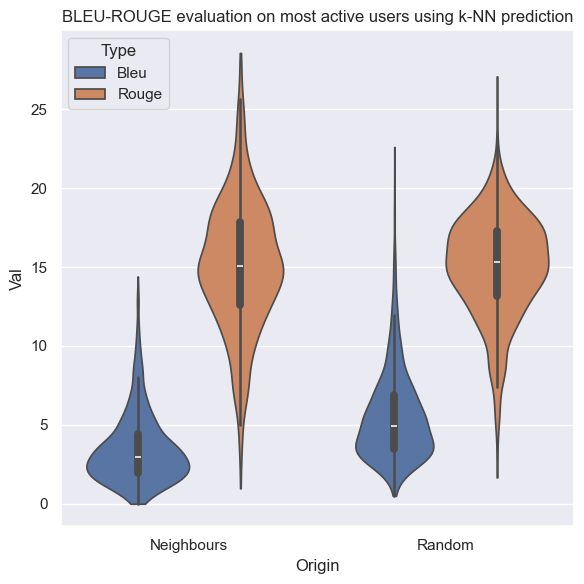

In [ ]:
test = bleu_rouge("most active", "k-NN", "neighbours") 
#test = bleu_rouge("most active", "k-NN", "neighbours", well_predicted=True)
# test = bleu_rouge("most active", "k-NN", "random") -> OK
#test = bleu_rouge("most active", "k-NN", "random", well_predicted=True) -> OK

#test = bleu_rouge("most active", "NMF", "random") -> OK
#test = bleu_rouge("most active", "NMF", "random", well_predicted=True) -> OK
#test = bleu_rouge("most active", "NMF", "random",nbj=3) -> OK
# test = bleu_rouge("most active", "NMF", "neighbours") -> OK

# test = bleu_rouge("random", "k-NN", "neighbours") 
# test = bleu_rouge("random", "k-NN", "neighbours", well_predicted=True) 
# test = bleu_rouge("random", "k-NN", "random")
# test = bleu_rouge("random", "k-NN", "random", well_predicted=True)

# test = bleu_rouge("random", "NMF", "random") 
# test = bleu_rouge("random", "NMF", "random", well_predicted=True)
# test = bleu_rouge("random", "NMF", "random",nbj=3)
# test = bleu_rouge("random", "NMF", "neighbours")

plot_bleu_rouge('most active', 'k-NN')


Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

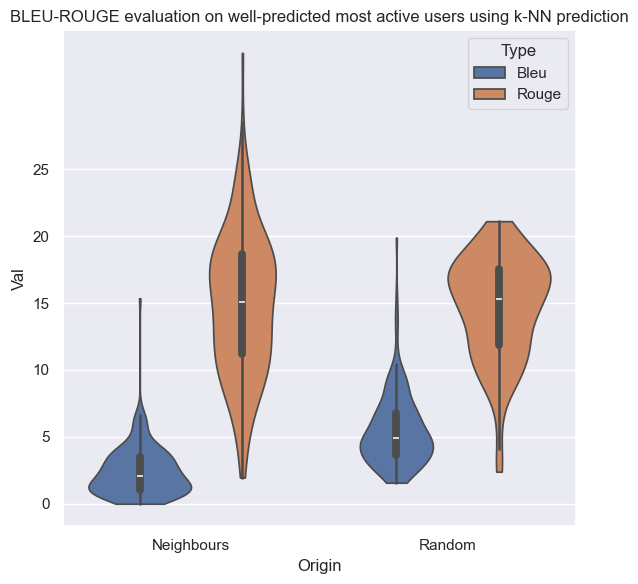

In [ ]:
plot_bleu_rouge('most active', 'k-NN',well_predicted=True)

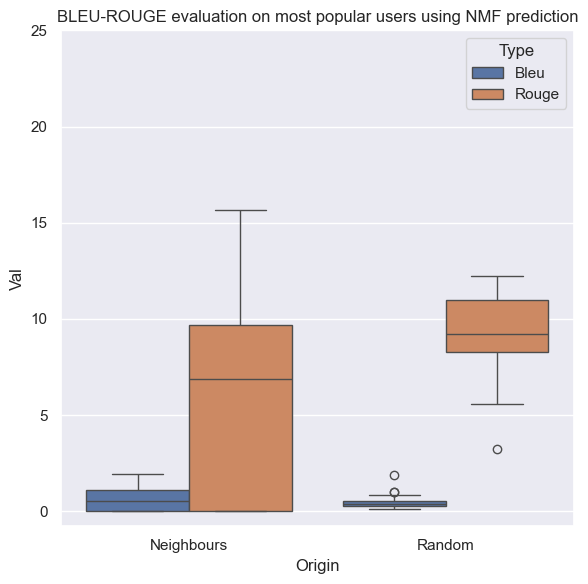

In [ ]:
# NMF avec 1 jeu/user
plot_bleu_rouge('most active', 'NMF')

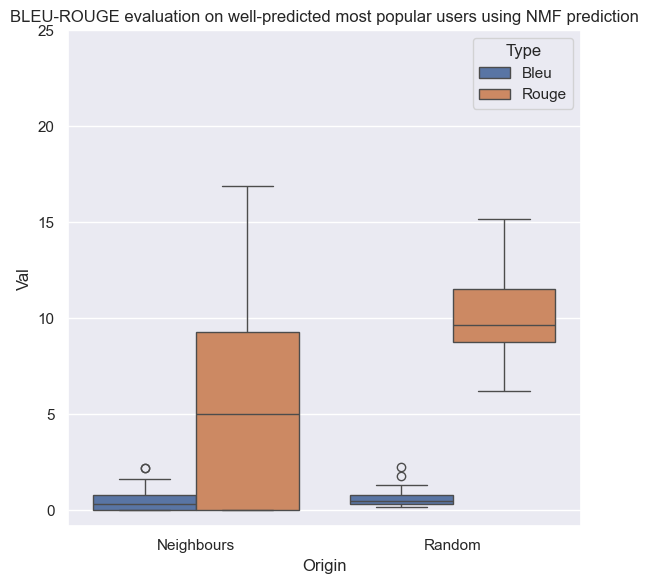

In [ ]:
plot_bleu_rouge('most active', 'NMF',well_predicted=True)

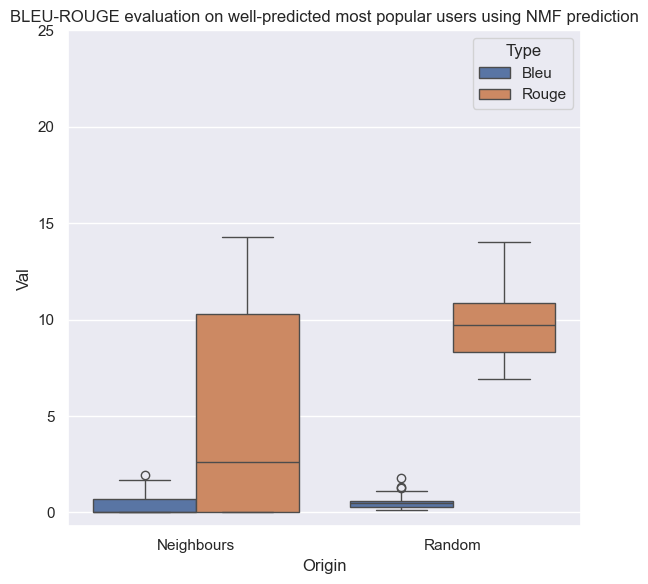

In [ ]:
# NMF avec 20 jeux 
plot_bleu_rouge('most active', 'NMF',well_predicted=True,nbj=20)

Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

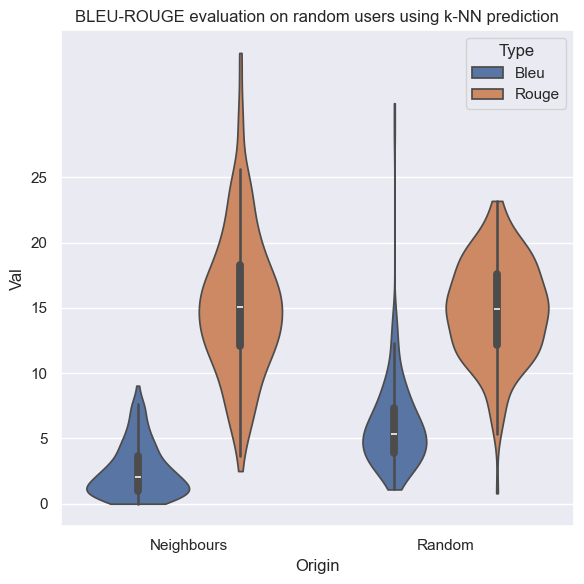

In [ ]:
# RANDOM k-NN: 
plot_bleu_rouge("random", "k-NN")

Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

Début user selection


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-le

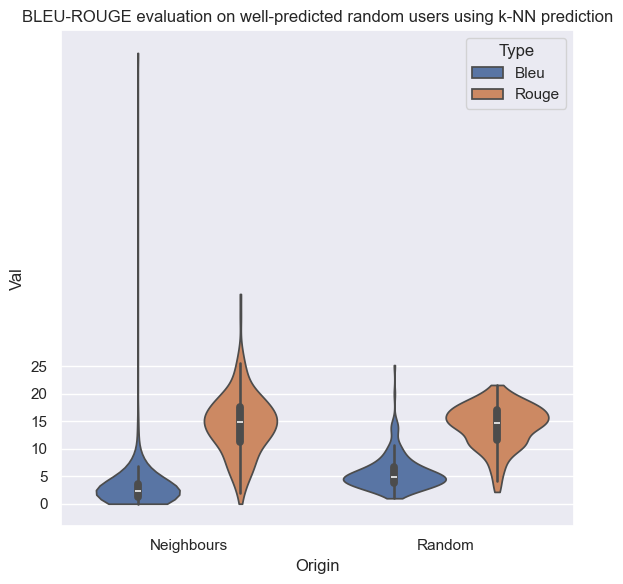

In [ ]:
# RANDOM k-NN well predicted
plot_bleu_rouge("random", "k-NN",well_predicted=True)

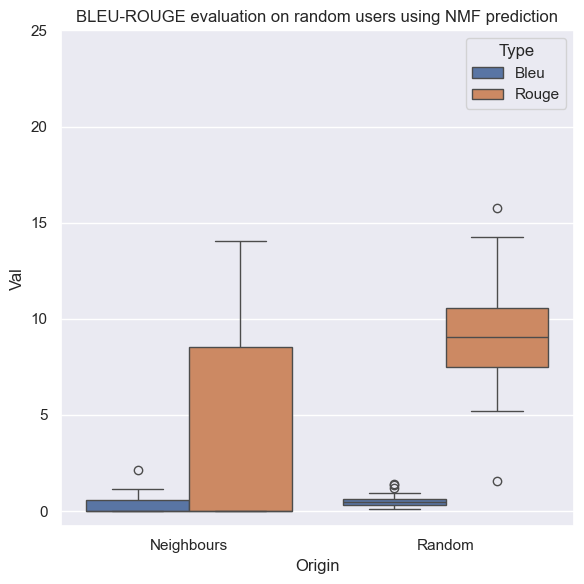

In [ ]:
# RANDOM NMF
plot_bleu_rouge("random", "NMF")

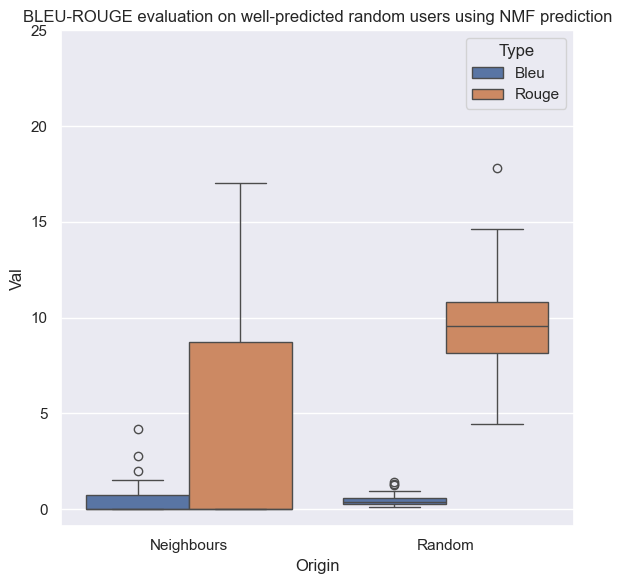

In [ ]:
# RANDOM NMF well_predicted
plot_bleu_rouge("random", "NMF", well_predicted=True)

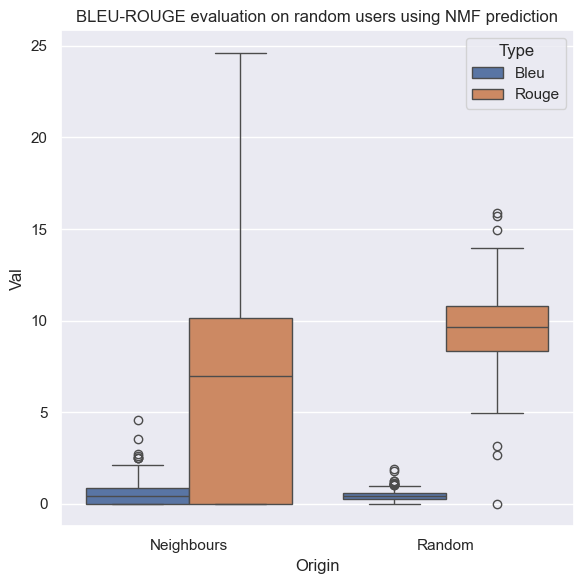

In [ ]:
# Random NMF 20 jeux 
plot_bleu_rouge("random", "NMF",nbj=5)

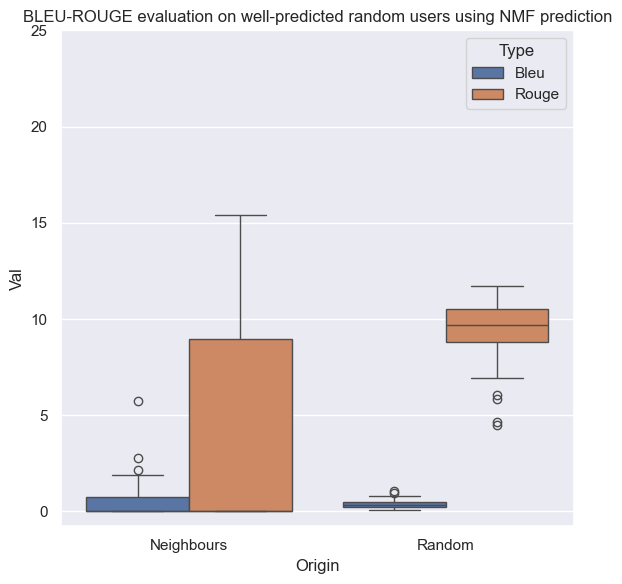

In [ ]:
# Random NMF 20 jeux well -predicted 
plot_bleu_rouge("random", "NMF",well_predicted=True, nbj=5)

# Old Version

In [ ]:
# Type d'évaluation 1 : jeux biens prédits parmi les 50 plus gros users (avec les 20 users les plus proches)

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(50)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
print("Taill res : ",  len(get_KNN(sim_matrix,20,1)))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        ind_to_id(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating_knn(rev_filter,ind_to_id(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], ind_to_id(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], ind_to_id(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")


Taill res :  20


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

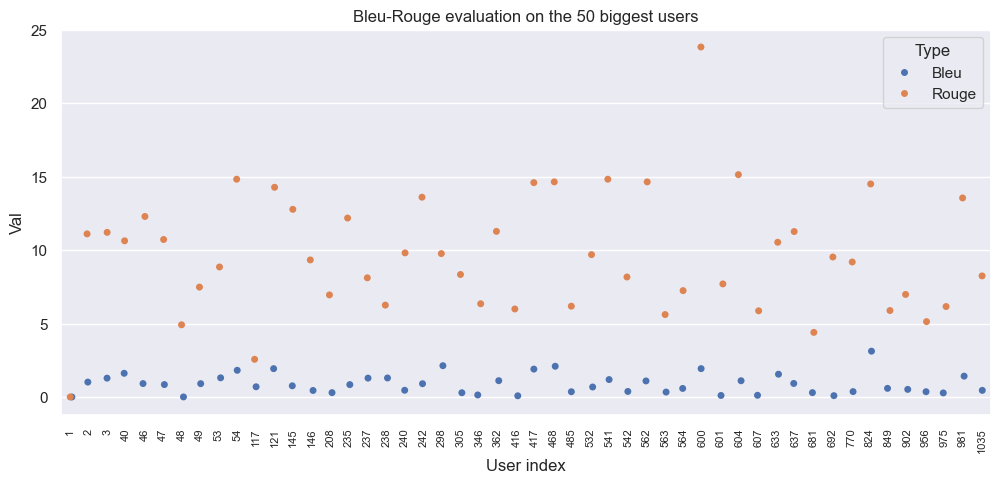

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-Rouge evaluation on the 50 biggest users")
plt.savefig('img_bleu_rouge/50_big_close.png')

In [ ]:
# Type d'évaluation 2 : 50 plus gros users parmi les mieux prédits (knn 20 users) 

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(112)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

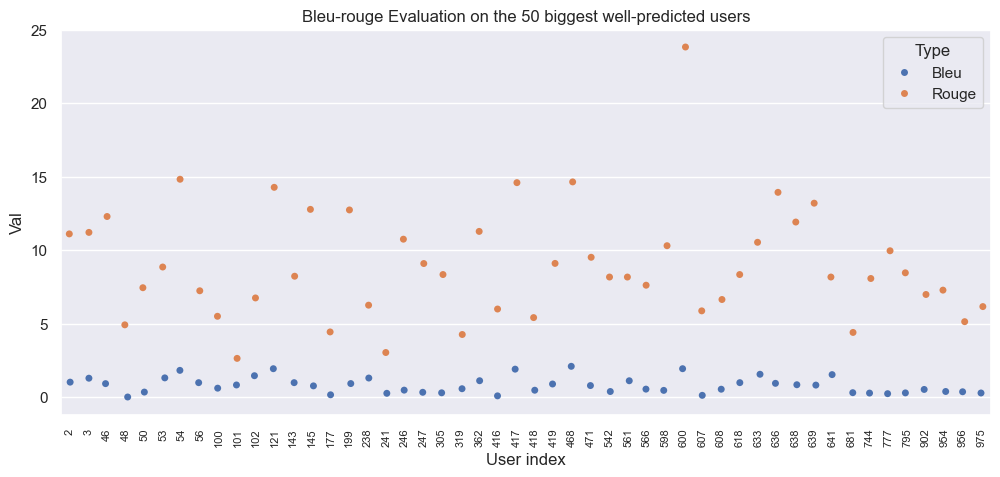

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-rouge Evaluation on the 50 biggest well-predicted users")
plt.savefig('img_bleu_rouge/50_predict_close.png')

In [ ]:
# Type d'évaluation 3 : 50 plus gros users parmis les mals prédits 

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(500)["User index"].to_numpy()

df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]
df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

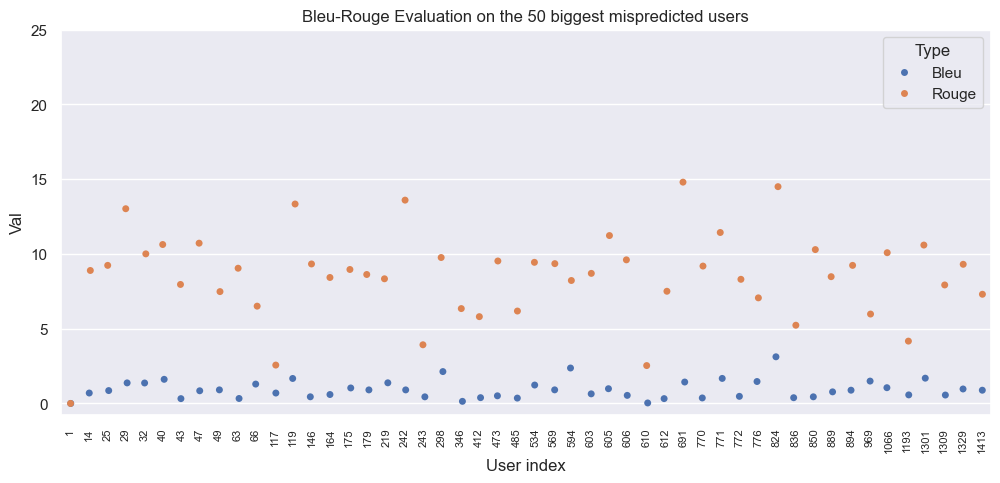

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-Rouge Evaluation on the 50 biggest mispredicted users")
plt.savefig('img_bleu_rouge/50_bad_predict_close.png')

In [ ]:
# Type d'évaluation 4 : 50 users random
import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = random.sample(sorted(assoc["User index"].to_numpy()), k=50)
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

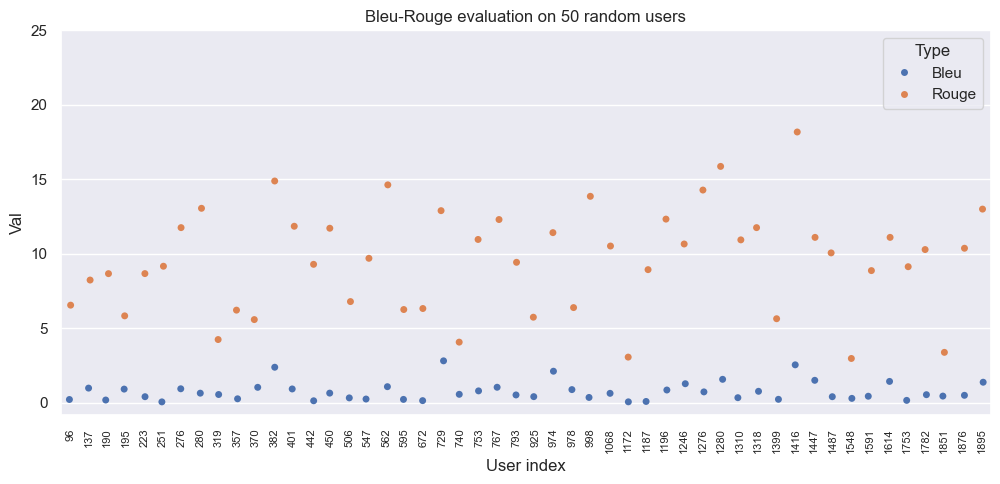

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-Rouge evaluation on 50 random users")
plt.savefig('img_bleu_rouge/50_random_close.png')

In [ ]:
# Type 5 :users les plus distants pour users random
import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
#famous_users = random.sample(sorted(assoc["User index"].to_numpy()), k=50)
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix, 20,x))
df['Farests'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

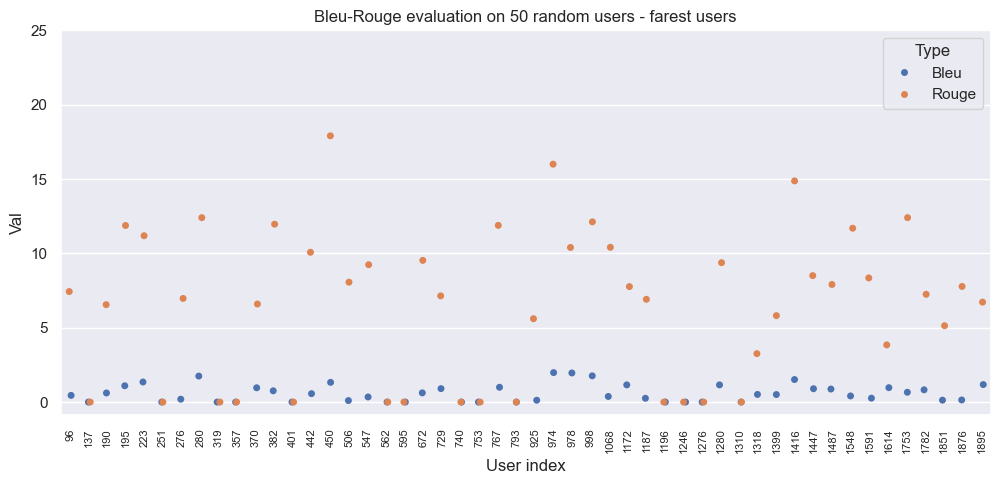

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-Rouge evaluation on 50 random users - farest users")
plt.savefig('img_bleu_rouge/50_random_far.png')

In [ ]:
# Type 6 : Biggest users - farest neighbours

import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(50)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix, 20, x))
df['Farests'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

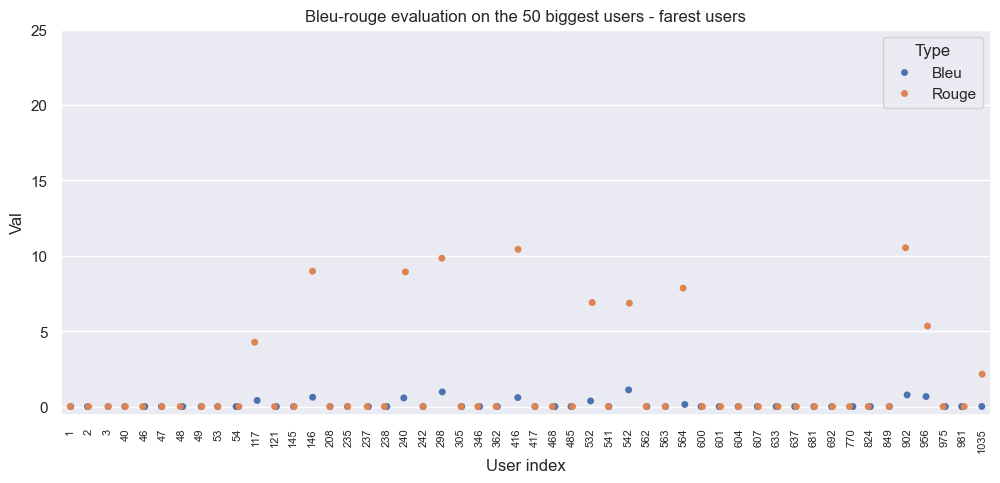

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-rouge evaluation on the 50 biggest users - farest users")
plt.savefig('img_bleu_rouge/50_big_far.png')

In [ ]:
# Type d'évaluation 7 : 50 plus gros users parmi bien prédits  - farest neighbours

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(112)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Farests'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]
print(df.shape)
df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
df

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


(50, 6)


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

,User index,Voisins index,Farests,Recommended game,Pred Rating,Real Rating,Bleu,Rouge
0,121,"[638, 117, 692, 563, 600, 1, 561, 902, 1261, 4...","[480, 1177, 1084, 1502, 285, 886, 585, 139, 13...",9476,10.000000,10.0,0.000000,0.000000
3,46,"[1, 176, 29, 1496, 384, 1345, 693, 198, 780, 1...","[894, 103, 4, 702, 715, 21, 990, 209, 1310, 13...",1926,10.000000,10.0,0.000000,0.000000
6,633,"[1416, 605, 615, 48, 541, 571, 564, 313, 423, ...","[1166, 1321, 1929, 959, 1742, 1029, 1839, 1408...",8130,10.000000,10.0,0.000000,0.000000
7,416,"[439, 436, 959, 589, 1051, 1339, 1316, 1024, 9...","[1242, 810, 71, 936, 1202, 1318, 402, 1826, 11...",3183,10.000000,10.0,0.596557,10.426540
8,956,"[1573, 958, 704, 1523, 1140, 453, 1913, 1833, ...","[1073, 1753, 1020, 804, 1442, 1812, 887, 1217,...",1077,10.000000,10.0,0.664690,5.338691
9,145,"[976, 692, 717, 601, 681, 1, 121, 504, 607, 10...","[731, 168, 242, 1343, 180, 335, 1765, 127, 176...",6924,9.600000,8.6,0.000000,0.000000
10,681,"[976, 1036, 605, 145, 117, 612, 1272, 601, 902...","[652, 1192, 1832, 874, 1882, 889, 443, 1883, 3...",6859,10.000000,8.8,0.000000,0.000000
12,902,"[117, 599, 302, 1358, 605, 976, 48, 1061, 194,...","[1479, 1669, 513, 1017, 1366, 348, 1863, 1217,...",9225,9.300000,8.3,0.770977,10.526315
15,54,"[1399, 1365, 500, 4, 1074, 57, 331, 1175, 112,...","[702, 935, 1473, 443, 533, 896, 360, 866, 1078...",10118,10.000000,9.0,0.000000,0.000000
18,468,"[817, 80, 1743, 121, 1560, 302, 1267, 1929, 11...","[756, 570, 654, 1919, 1475, 1051, 1210, 1669, ...",2360,10.000000,10.0,0.000000,0.000000


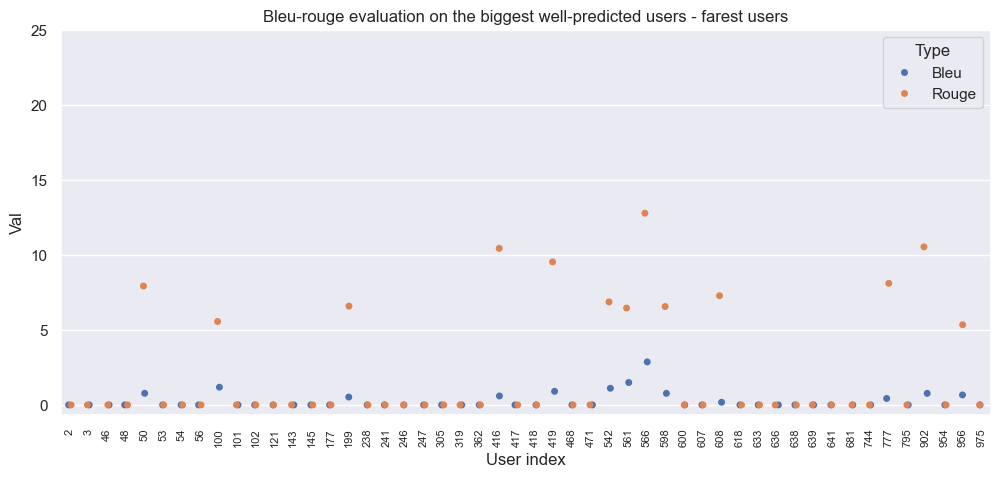

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-rouge evaluation on the biggest well-predicted users - farest users")
plt.savefig('img_bleu_rouge/50_predict_far.png')

In [ ]:
# Type d'évaluation 8 : 50 plus gros users mal prédits - distants 
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(500)["User index"].to_numpy()

df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Farests'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,100,x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]
df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Farests']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

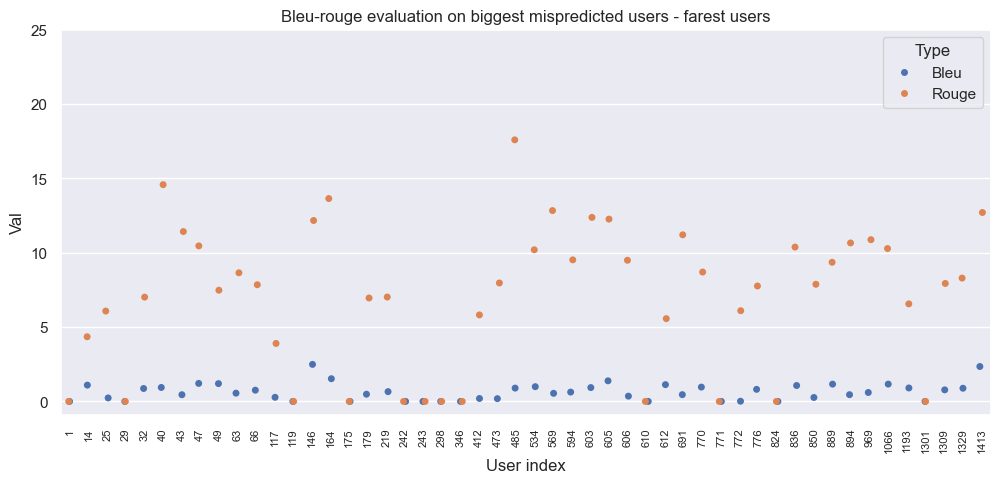

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-rouge evaluation on biggest mispredicted users - farest users")
plt.savefig('img_bleu_rouge/50_bad_predict_far.png')

In [ ]:

rev_filter # data centrée

np.random.seed(45)
# Tirer un user au hasard 
# k-NN sur 20
# regarder le jeu qui a le plus de user commun
# generate user-game matrix

# Construction assoc


# Sélection aléatoire user
user_indices = assoc["User index"].to_numpy()





print(famous_users)

for user in famous_users : 
# df : user_ref_id (le vrai), game_id évalué, voisin id, avis du voisin id, bleu, rouge
    #user = choice(user_indices)
    user_ind = assoc.loc[user,"User id"]
    print(user, " : ", user_ind)

    # k-nn
    neighbours = get_KNN(sim_matrix,20,user)
    print("Voisins : ", neighbours)

    neighbours_id = assoc[ np.isin(assoc['User index'],neighbours)]['User id'].to_numpy()
    neighbours_id
    neighbours_avis = filtered_centrd_data[(filtered_centrd_data['User id'].isin(neighbours_id)) | (filtered_centrd_data['User id'] == user_ind)]
    # Filtrer les jeux notés par user_ind
    user_games = filtered_centrd_data[filtered_centrd_data["User id"] == user_ind]["Game id"].unique()

    # Exclure les notes du user_ind -> garder uniquement les voisins !!!!!
    df_filtered = neighbours_avis[neighbours_avis["User id"] != user_ind]
    # Calculer la moyenne des notes pour chaque jeu
    game_avg_ratings = df_filtered.groupby("Game id")["Rating"].mean().reset_index()

    # Garder uniquement les jeux que user_ind a notés
    df_result = game_avg_ratings[game_avg_ratings["Game id"].isin(user_games)]
    # Renommer la colonne moyenne des notes
    df_result = df_result.rename(columns={"Rating": "Mean Rating"})
    df_result.sort_values('Mean Rating', ascending=False,inplace=True)

    best_game = df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"]
    print("Jeu reco : ",int(best_game))
    df_result.head(10)

    neighbours_avis = neighbours_avis[neighbours_avis['Game id'] == best_game][['User id','Game id']]
    #df = ft.get_bleu_rouge(best_game,user_ind,assoc,neighbours,neighbours_avis)
    print("ID des voisins et du joueur : ", neighbours_avis['User id'].to_numpy())
    print("ID du ref : ",user_ind)
    ref_avis = rev_filter[(rev_filter['User id'] == user_ind) & (rev_filter['Game id'] == best_game)].index[0]
    print("Ref avis :", ref_avis)
    br = neighbours_avis.copy(True)
    br = br[br['User id'] != user_ind].reset_index()
    br.drop('Game id', axis = 1, inplace=True)
    br.columns = ['Avis id', 'User id']
    br.sort_values('Avis id', ascending=True)

    lem = pd.read_csv('generated_data/avis_lemmatized.csv',index_col=0)
    #lem_n = lem[np.isin(lem.index, br['Avis id'].to_numpy())]
    br = br.merge(lem,left_on='Avis id', right_index=True, how="inner") # merge left on right_index = True, left_on avis id
    #br['Lemma'] = lem_n['Comment'].to_numpy()
    #if(ref_avis not in lem.index) : continue
    ref_lem = lem.loc[ref_avis,'Comment']

    blue_scorer = BLEU()
    rouge_scorer = Rouge()

    br['Bleu'] = br['Comment'].apply(lambda x : blue_scorer.sentence_score(hypothesis=x,references=[ref_lem]).score/100)
    #br['Bleu nltk'] = br['Comment'].apply(lambda x : bleu_score.sentence_bleu(hypothesis=[list(x)],references=ref_lem))
    br['Rouge'] = br['Comment'].apply(lambda x : rouge_scorer.get_scores(hyps=x,refs=ref_lem)[0]["rouge-l"]["f"])
    br['User ref'] = [user_ind]*br.shape[0]
    br['Game rec'] = [best_game]*br.shape[0]
    br = br[['User ref', 'Game rec', 'Avis id', 'User id', 'Comment', 'Bleu', 'Rouge']]

    #bleu_rouge = pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
    #bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)
    bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)
bleu_rouge['Val'] = bleu_rouge['Val'].apply(lambda x : x*100)
bleu_rouge['User ref'] = bleu_rouge['User ref'].apply(lambda x : str(x))

[ 121   40    1   46  117  541  633  416  956  145  681   47  902  346
   49   54  235  601  468  562  237  208  532  242  485  240  637    2
  362  692  607  417   48  564  563  975  238  305  849    3  981  770
  604  146  824   53 1035  298  542  600  175  977  284  903  174  606
  565  825  421  385  561  744  177  104  185  618  636  608  239  828
 1193  638  566  693  302   32  418  246  143  639  320  829  598  773
  241   50  777  772  836  321  102  199  954   56  609   44   57  101
  641  329  419  471  795 1194  560  317  635  771  247  319  745  100
  833  776  245  774  775   59  347  176  371  603  624  622  110  250
  939  831  568  748  610   61  612   51  602  746   23  853  614  554
  691  119  456  834  839   45   29  423  596    6  615  599  643  243
  567  505  605 1004  350  412  570  373   58  841  616  907  623  749
  796   14  118   55  942  290  510  473 1046  569   65  251  534  249
  780  970 1003 1326  905  161  644 1274  976   42  422   66  722  971
  420 

C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


40  :  83
Voisins :  [ 177  117  599  121  902  605 1061 1272  772  610  569   59  600  607
  302  681  618 1037 1460  692]
Jeu reco :  6000
ID des voisins et du joueur :  [ 208   83 2049]
ID du ref :  83
Ref avis : 78980


It is recommended to enable `effective_order` for sentence-level BLEU.


1  :  1
Voisins :  [ 332   46  121  145  379  629  101  123  102  362  167  407  245    3
  118 1485  692  464  704  197]
Jeu reco :  10118
ID des voisins et du joueur :  [208   1]
ID du ref :  1
Ref avis : 112494


It is recommended to enable `effective_order` for sentence-level BLEU.


46  :  91
Voisins :  [   1  176   29 1496  384 1345  693  198  780  104 1034  599  526  470
  117  737  874  522 1487  315]
Jeu reco :  1926
ID des voisins et du joueur :  [201  91]
ID du ref :  91
Ref avis : 131887


It is recommended to enable `effective_order` for sentence-level BLEU.


117  :  201
Voisins :  [ 615  541  605  902  471  121  942  233   59   48  563  607 1061  362
 1272  627 1413  681  773  772]
Jeu reco :  2736
ID des voisins et du joueur :  [ 201 1926]
ID du ref :  201
Ref avis : 122800


It is recommended to enable `effective_order` for sentence-level BLEU.


541  :  1724
Voisins :  [ 117  563   59  773  942  633  235  471  121  243  615  374  627  598
  634  856  570 1004 1067 1157]
Jeu reco :  5237
ID des voisins et du joueur :  [ 208 1724]
ID du ref :  1724
Ref avis : 73748


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


633  :  1936
Voisins :  [1416  605  615   48  541  571  564  313  423 1358  606  971 1854  760
 1701  291  902   59  976  385]
Jeu reco :  8130
ID des voisins et du joueur :  [1936 1904]
ID du ref :  1936
Ref avis : 134154


It is recommended to enable `effective_order` for sentence-level BLEU.


416  :  1191
Voisins :  [ 439  436  959  589 1051 1339 1316 1024  969 1687 1069 1859 1368  113
 1534  529 1797  751  290  690]
Jeu reco :  3183
ID des voisins et du joueur :  [1191 6656]
ID du ref :  1191
Ref avis : 17490


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


956  :  2747
Voisins :  [1573  958  704 1523 1140  453 1913 1833 1872 1571  896  283  589 1107
 1687  445 1072 1799 1162 1191]
Jeu reco :  1077
ID des voisins et du joueur :  [2747 4735]
ID du ref :  2747
Ref avis : 52050


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


145  :  291
Voisins :  [ 976  692  717  601  681    1  121  504  607 1061  602  612  629   48
  245  293 1666  117  716  103]
Jeu reco :  6924
ID des voisins et du joueur :  [  1 291]
ID du ref :  291
Ref avis : 25974


It is recommended to enable `effective_order` for sentence-level BLEU.


681  :  1998
Voisins :  [ 976 1036  605  145  117  612 1272  601  902  599  302  607  194  772
  748  614  572  269  641   48]
Jeu reco :  6859
ID des voisins et du joueur :  [ 201 1998]
ID du ref :  1998
Ref avis : 123998


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


47  :  92
Voisins :  [1231  539  976 1719  473 1475  641 1622 1813  620  605  681  902   49
 1210  982  612 1095 1197  836]
Jeu reco :  7815
ID des voisins et du joueur :  [  92 2878]
ID du ref :  92
Ref avis : 58039


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


902  :  2584
Voisins :  [ 117  599  302 1358  605  976   48 1061  194  772  627  681  121  284
  571  692  621   40  385  615]
Jeu reco :  9225
ID des voisins et du joueur :  [  93 2584]
ID du ref :  2584
Ref avis : 18278


It is recommended to enable `effective_order` for sentence-level BLEU.


346  :  885
Voisins :  [  48  610  233  772 1740  184  620   59  605  627  902 1283  302  567
  829  316  239  117  667 1414]
Jeu reco :  8659
ID des voisins et du joueur :  [ 93 885]
ID du ref :  885
Ref avis : 41205


It is recommended to enable `effective_order` for sentence-level BLEU.


49  :  94
Voisins :  [1901 1929 1094  607   72  235   82 1090   57  309 1532  609   47 1246
   53  610  639  648  635  780]
Jeu reco :  7892
ID des voisins et du joueur :  [  94 2282]
ID du ref :  94
Ref avis : 129042


It is recommended to enable `effective_order` for sentence-level BLEU.


54  :  99
Voisins :  [1399 1365  500    4 1074   57  331 1175  112   51  682  503 1398  966
 1279  811 1769  121  860 1036]
Jeu reco :  10118
ID des voisins et du joueur :  [208  99]
ID du ref :  99
Ref avis : 112501


It is recommended to enable `effective_order` for sentence-level BLEU.


235  :  574
Voisins :  [ 636  541  642  828   49  933  607 1270 1854  605 1695  742  841  117
 1556  907  467  671  177  565]
Jeu reco :  5619
ID des voisins et du joueur :  [201 574]
ID du ref :  574
Ref avis : 124373


It is recommended to enable `effective_order` for sentence-level BLEU.


601  :  1900
Voisins :  [ 717  692  145 1141  629  681 1330  615 1767  287  612 1454  748  117
 1271 1739  283  846  214 1061]
Jeu reco :  2476
ID des voisins et du joueur :  [1900 2247]
ID du ref :  1900
Ref avis : 73734


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


468  :  1342
Voisins :  [ 817   80 1743  121 1560  302 1267 1929  117  599 1094 1089 1901  902
  825  854  571  166  770  772]
Jeu reco :  2360
ID des voisins et du joueur :  [1342 2385]
ID du ref :  1342
Ref avis : 92238


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


562  :  1816
Voisins :  [1447  885 1583 1618  722  795 1342 1482  604  817  608 1490  635  402
  627  914  954   51 1577 1726]
Jeu reco :  5423
ID des voisins et du joueur :  [1816 1926]
ID du ref :  1816
Ref avis : 8687


It is recommended to enable `effective_order` for sentence-level BLEU.


237  :  576
Voisins :  [ 428  641  584 1239  870 1013 1257 1196  312  214  663 1734 1551 1062
  246  825   59  539 1193 1277]
Jeu reco :  2360
ID des voisins et du joueur :  [ 576 2385]
ID du ref :  576
Ref avis : 92239


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


208  :  455
Voisins :  [1555 1704  117  630 1349  121  235  541 1193  719  373   21  710 1920
  532 1187 1036  565 1312  612]
Jeu reco :  3308
ID des voisins et du joueur :  [201 455]
ID du ref :  455
Ref avis : 114178


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


532  :  1685
Voisins :  [1679  243 1839  981 1696  975  976  121  498 1036  824  569 1849 1299
  457  615 1017  223  604 1274]
Jeu reco :  713
ID des voisins et du joueur :  [ 208 1685 2877]
ID du ref :  1685
Ref avis : 64366


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


242  :  581
Voisins :  [1487 1439   48 1065  621   62  722  569  618  567  319  606 1784 1857
 1540  607  825   99 1634 1415]
Jeu reco :  6536
ID des voisins et du joueur :  [2385  581]
ID du ref :  581
Ref avis : 136206


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


485  :  1434
Voisins :  [ 782  662  691  301  501 1483 1530  188 1635 1436 1765  626 1223  362
  629  812 1723 1529  361 1181]
Jeu reco :  710
ID des voisins et du joueur :  [1434 2048]
ID du ref :  1434
Ref avis : 63399


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


240  :  579
Voisins :  [1358  817  439  469 1584 1007  914  612 1053 1267  320  976  975 1515
  363 1080  770 1071  317  184]
Jeu reco :  4437
ID des voisins et du joueur :  [2857  579]
ID du ref :  579
Ref avis : 46724


It is recommended to enable `effective_order` for sentence-level BLEU.


637  :  1940
Voisins :  [ 627  579   59  654  290  453 1927  876 1088 1272  902  430  994  324
  796  427 1155  604  829 1619]
Jeu reco :  4910
ID des voisins et du joueur :  [1940 1926 1205]
ID du ref :  1940
Ref avis : 105308


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


2  :  2
Voisins :  [1238 1535  776  172  844  284 1261  290  770  841  321  878 1037 1828
 1381 1454  907  635   64  665]
Jeu reco :  9476
ID des voisins et du joueur :  [   2  658 3628 2589]
ID du ref :  2
Ref avis : 52256


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


362  :  934
Voisins :  [ 662  692  188  117 1765  975  283 1530  298  873 1046  101  121  690
 1191  774  566   57    1 1520]
Jeu reco :  3788
ID des voisins et du joueur :  [208 934]
ID du ref :  934
Ref avis : 90762


It is recommended to enable `effective_order` for sentence-level BLEU.


692  :  2049
Voisins :  [ 298  748  717 1585  362  121 1387  635  145  601  691  853  982  833
  975  101  778  796  902  510]
Jeu reco :  2549
ID des voisins et du joueur :  [ 208 2049]
ID du ref :  2049
Ref avis : 34360


It is recommended to enable `effective_order` for sentence-level BLEU.


607  :  1906
Voisins :  [ 565  770 1439  177 1574  117  510 1362  635  386  776 1061 1926  828
  774  620   49  908  505  748]
Jeu reco :  9504
ID des voisins et du joueur :  [ 201 1906 2247 1533 1567]
ID du ref :  1906
Ref avis : 22827


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


417  :  1192
Voisins :  [ 321  604  635 1119 1532 1164  746  770 1747  609  424 1154  692  437
  568   80  386  919  788 1241]
Jeu reco :  145
ID des voisins et du joueur :  [1192 4595]
ID du ref :  1192
Ref avis : 59922


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


48  :  93
Voisins :  [1061  615  803 1414  976  581  117  975  410  621  902  605  613  633
  346  772 1416  852   52  620]
Jeu reco :  1063
ID des voisins et du joueur :  [  93 2308]
ID du ref :  93
Ref avis : 53534


It is recommended to enable `effective_order` for sentence-level BLEU.


564  :  1818
Voisins :  [1361 1358 1416  233   72 1343 1248  633  728  239  772 1729 1733  760
  723 1231  567 1701  571  391]
Jeu reco :  8428
ID des voisins et du joueur :  [ 578 1818]
ID du ref :  1818
Ref avis : 20039


It is recommended to enable `effective_order` for sentence-level BLEU.


563  :  1817
Voisins :  [ 942  471 1193 1035   50  541  236  117  121  914  605  890 1860  620
  565  358 1205  638  627 1866]
Jeu reco :  6843
ID des voisins et du joueur :  [ 208  201 1817]
ID du ref :  1817
Ref avis : 86642


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


975  :  2857
Voisins :  [  48  692  362  976  605  897  833  612  851  117  240 1549  943  774
 1244   57  576  558  720 1017]
Jeu reco :  9850
ID des voisins et du joueur :  [  93 2857]
ID du ref :  2857
Ref avis : 28302


It is recommended to enable `effective_order` for sentence-level BLEU.


238  :  577
Voisins :  [ 704  977 1394  121 1623  966  236 1193 1275 1143 1630   57  726  275
  403  549 1685  185  621   40]
Jeu reco :  2551
ID des voisins et du joueur :  [208 577]
ID du ref :  577
Ref avis : 34384


It is recommended to enable `effective_order` for sentence-level BLEU.


305  :  732
Voisins :  [1826  966 1051  746   35  833  807 1445 1862 1001  783 1202 1612  777
 1447  599  511  507 1603 1537]
Jeu reco :  9079
ID des voisins et du joueur :  [2285  732]
ID du ref :  732
Ref avis : 39942


It is recommended to enable `effective_order` for sentence-level BLEU.


849  :  2430
Voisins :  [ 974 1787 1242 1819  182 1167  757  563 1119 1810  473  621 1061 1285
  942  902  963  746 1087  605]
Jeu reco :  7507
ID des voisins et du joueur :  [2430 1904]
ID du ref :  2430
Ref avis : 111779


It is recommended to enable `effective_order` for sentence-level BLEU.


3  :  3
Voisins :  [1447  919  402 1275  704 1826  948 1839 1482 1862   71 1550 1842  968
  781 1876  223 1899 1595  421]
Jeu reco :  3576
ID des voisins et du joueur :  [1196    3]
ID du ref :  3
Ref avis : 20932


It is recommended to enable `effective_order` for sentence-level BLEU.


981  :  2877
Voisins :  [1026  317 1023  522  532  748  844  692 1078 1353  903  597 1010 1573
  283 1638  780  887 1050 1012]
Jeu reco :  3578
ID des voisins et du joueur :  [2049 2877]
ID du ref :  2877
Ref avis : 74810


It is recommended to enable `effective_order` for sentence-level BLEU.


770  :  2272
Voisins :  [ 907  607  177 1193 1793  565 1358  117  636  758  605  635  417 1272
  902  773  427 1738  290 1080]
Jeu reco :  3593
ID des voisins et du joueur :  [ 201 2272]
ID du ref :  2272
Ref avis : 95261


It is recommended to enable `effective_order` for sentence-level BLEU.


604  :  1903
Voisins :  [1447  417 1280 1409 1241  402 1142 1036 1256  635  905 1862 1896  860
 1541 1741  781  562  579   51]
Jeu reco :  3929
ID des voisins et du joueur :  [1816 1903]
ID du ref :  1903
Ref avis : 110133


It is recommended to enable `effective_order` for sentence-level BLEU.


146  :  292
Voisins :  [ 776  635 1667  671 1671  878  569  607  668  805  796 1478  177  841
 1490  166  986   67 1577 1905]
Jeu reco :  4199
ID des voisins et du joueur :  [1938  292 1906 2278]
ID du ref :  292
Ref avis : 100155


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


824  :  2384
Voisins :  [ 635   60 1629 1176  901 1942 1840 1549  610  791  874 1036 1193  177
  636  842 1317  770  299  121]
Jeu reco :  920
ID des voisins et du joueur :  [ 208 2384]
ID du ref :  2384
Ref avis : 73653


It is recommended to enable `effective_order` for sentence-level BLEU.


53  :  98
Voisins :  [1574 1059  879   50 1572  598  565   87  236  616 1746 1858  576 1004
 1117  622  358 1035  432 1101]
Jeu reco :  9670
ID des voisins et du joueur :  [  98 1207]
ID du ref :  98
Ref avis : 2852


It is recommended to enable `effective_order` for sentence-level BLEU.


1035  :  2994
Voisins :  [ 471   27  563  129  942  570 1851  302 1798 1263 1903 1554   50  358
   53  117 1205 1422 1729 1824]
Jeu reco :  8275
ID des voisins et du joueur :  [2994  201   95]
ID du ref :  2994
Ref avis : 42264


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


298  :  702
Voisins :  [ 370  692 1014  522  779 1308  165  853  682  362  874  864 1559  769
 1796 1048   69  662 1707  412]
Jeu reco :  145
ID des voisins et du joueur :  [ 702 1146]
ID du ref :  702
Ref avis : 59924


It is recommended to enable `effective_order` for sentence-level BLEU.


542  :  1725
Voisins :  [1611 1189 1145  603 1757  612  224  246   99  290 1036  236  990  456
  605  573  778  637 1608  636]
Jeu reco :  6774
ID des voisins et du joueur :  [1725 1940]
ID du ref :  1725
Ref avis : 42174


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


600  :  1899
Voisins :  [ 402  121 1447  413  715 1739  964 1067  319  545 1628 1375 1550  796
  261   71 1862  902 1062  400]
Jeu reco :  920
ID des voisins et du joueur :  [ 208 1899]
ID du ref :  1899
Ref avis : 73655


It is recommended to enable `effective_order` for sentence-level BLEU.


175  :  382
Voisins :  [1412 1034  511 1401 1829 1565  644  469  437 1504 1817  874 1154 1731
 1631 1897 1642 1485 1912  980]
Jeu reco :  1875
ID des voisins et du joueur :  [ 382 1947]
ID du ref :  382
Ref avis : 21334


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


977  :  2859
Voisins :  [ 565  238 1414 1497 1579 1793  881 1413 1120 1039  856 1699 1358 1642
  942  541 1841  770  735   91]
Jeu reco :  1193
ID des voisins et du joueur :  [1819 2859 2705]
ID du ref :  2859
Ref avis : 129618


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


284  :  638
Voisins :  [ 902  710  772  313  117 1361  233  605  770 1131    2  541  614 1061
  221 1330  194  456  819 1650]
Jeu reco :  3831
ID des voisins et du joueur :  [ 201 2272  638]
ID du ref :  638
Ref avis : 88045


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


903  :  2585
Voisins :  [1238 1623 1464 1440 1304  117 1281 1914  546  524 1339  615  634 1087
  185  981  177 1114 1903 1744]
Jeu reco :  4451
ID des voisins et du joueur :  [2585 8018]
ID du ref :  2585
Ref avis : 88892


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


174  :  377
Voisins :  [1062  224  617 1638  635  692  188    7  386 1189 1036  303  844    3
  620  400   67 1243  319  346]
Jeu reco :  65
ID des voisins et du joueur :  [ 377 1021]
ID du ref :  377
Ref avis : 87034


It is recommended to enable `effective_order` for sentence-level BLEU.


606  :  1905
Voisins :  [  93  671 1554   48 1716  633 1793  343 1905 1358 1692   64 1629 1417
  667  922  758  668  902 1738]
Jeu reco :  305
ID des voisins et du joueur :  [  93 1905]
ID du ref :  1905
Ref avis : 29406


It is recommended to enable `effective_order` for sentence-level BLEU.


565  :  1819
Voisins :  [ 607  737  942  177  758 1039  907 1653 1300   59   53 1414  770 1517
  563  627 1574  839 1413 1825]
Jeu reco :  7058
ID des voisins et du joueur :  [2272 1819]
ID du ref :  1819
Ref avis : 84054


It is recommended to enable `effective_order` for sentence-level BLEU.


825  :  2385
Voisins :  [1088  302  571 1061  615  233 1416 1650 1600  567  614  465  581  772
 1299 1453  976 1456  921 1335]
Jeu reco :  5682
ID des voisins et du joueur :  [2385 1825]
ID du ref :  2385
Ref avis : 97799


It is recommended to enable `effective_order` for sentence-level BLEU.


421  :  1196
Voisins :  [1669    3 1513  919 1149 1648   89  440  435 1495  705  176 1468 1267
  710 1344 1442  119 1324   18]
Jeu reco :  9402
ID des voisins et du joueur :  [1210 3815 1196]
ID du ref :  1196
Ref avis : 40248


It is recommended to enable `effective_order` for sentence-level BLEU.


385  :  1019
Voisins :  [1361 1511  233 1061 1000 1416  239  902 1272  599 1261  976  117 1701
  287  302   59  760  633  627]
Jeu reco :  4724
ID des voisins et du joueur :  [1019 4145]
ID du ref :  1019
Ref avis : 114856


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


561  :  1815
Voisins :  [ 667  236 1740 1041  121 1261 1004 1891 1061  638   65 1788 1035  664
  541 1205  985  880  385  235]
Jeu reco :  10118
ID des voisins et du joueur :  [ 208 1815]
ID du ref :  1815
Ref avis : 112493


It is recommended to enable `effective_order` for sentence-level BLEU.


744  :  2243
Voisins :  [1849 1839  239 1005 1151 1715  754 1144 1320  362 1565  121  585  622
  801 1105  893 1695  690  624]
Jeu reco :  1349
ID des voisins et du joueur :  [ 578 2243]
ID du ref :  2243
Ref avis : 131914


It is recommended to enable `effective_order` for sentence-level BLEU.


177  :  384
Voisins :  [ 607  565  770  598 1848 1193 1261  636   40  635  892 1201  236 1624
  984  841  895 1716  471  422]
Jeu reco :  4971
ID des voisins et du joueur :  [1357 3427 1819 2889  384 2401]
ID du ref :  384
Ref avis : 129341


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


104  :  166
Voisins :  [ 367 1682  472  366  377  102  170  553 1353 1679   46    3 1005   44
  360  458  365 1317   25   22]
Jeu reco :  8130
ID des voisins et du joueur :  [ 88 166]
ID du ref :  166
Ref avis : 134183


It is recommended to enable `effective_order` for sentence-level BLEU.


185  :  403
Voisins :  [1166  941  928  420 1771  879 1345  985   67  626  121 1534  120  365
  172  293 1058  312  903  681]
Jeu reco :  2267
ID des voisins et du joueur :  [208 403]
ID du ref :  403
Ref avis : 80117


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


618  :  1917
Voisins :  [ 635 1704  774  745  117  607 1201  610  661  177  319   67  612  692
  626  816  236 1196  565  798]
Jeu reco :  8033
ID des voisins et du joueur :  [1917 3430]
ID du ref :  1917
Ref avis : 78454


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


636  :  1939
Voisins :  [ 985  235 1041  177  803  574 1341 1497  770  827 1261 1272 1036  563
  776  614  635 1893  607  615]
Jeu reco :  1535
ID des voisins et du joueur :  [2272 1939]
ID du ref :  1939
Ref avis : 93322


It is recommended to enable `effective_order` for sentence-level BLEU.


608  :  1907
Voisins :  [1936  896 1357  589 1534  402 1756 1872 1377 1447 1356  253  445 1321
 1826 1162 1140 1862 1442 1810]
Jeu reco :  1891
ID des voisins et du joueur :  [1907 4010]
ID du ref :  1907
Ref avis : 45939


It is recommended to enable `effective_order` for sentence-level BLEU.


239  :  578
Voisins :  [  59  605 1061  564  620  385 1272 1039  302   64 1358 1416  836 1936
 1210  346 1318  744  589  594]
Jeu reco :  65
ID des voisins et du joueur :  [ 578 3670]
ID du ref :  578
Ref avis : 87032


It is recommended to enable `effective_order` for sentence-level BLEU.


828  :  2388
Voisins :  [1478 1232 1507  607  833  235 1274 1689 1328  692  774  620   59 1435
 1667  510  117  782 1431  121]
Jeu reco :  6000
ID des voisins et du joueur :  [ 208 2049 2388]
ID du ref :  2388
Ref avis : 78990


It is recommended to enable `effective_order` for sentence-level BLEU.


1193  :  3427
Voisins :  [ 563  638  770  177  942 1519 1456  621 1141  565  471 1299 1261  735
 1643   81  117  184 1414   48]
Jeu reco :  6349
ID des voisins et du joueur :  [3427 1819]
ID du ref :  3427
Ref avis : 128279


It is recommended to enable `effective_order` for sentence-level BLEU.


638  :  1941
Voisins :  [ 121 1193  669 1519  563  184 1839  543  249  880  844  223  561 1116
  743  954  890   83 1787 1679]
Jeu reco :  3095
ID des voisins et du joueur :  [ 208 1941]
ID du ref :  1941
Ref avis : 110964


It is recommended to enable `effective_order` for sentence-level BLEU.


566  :  1820
Voisins :  [ 799 1781 1450  912 1765  362  622  384  821 1595 1226  246  654    6
  600  860 1787 1537  936  967]
Jeu reco :  918
ID des voisins et du joueur :  [1899 1820 1921 1958 2799]
ID du ref :  1820
Ref avis : 81106


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


693  :  2050
Voisins :  [ 406 1585 1447  402  526  407  306 1282  781 1888 1862 1239 1826 1842
  574   46    3 1234  968 1491]
Jeu reco :  1410
ID des voisins et du joueur :  [2050  733]
ID du ref :  2050
Ref avis : 14030


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


302  :  712
Voisins :  [ 772   27   59  825  605  902 1358  615 1061  313  129  971  627 1453
  567 1035  681  760  571  610]
Jeu reco :  10043
ID des voisins et du joueur :  [ 712 4328]
ID du ref :  712
Ref avis : 18031


It is recommended to enable `effective_order` for sentence-level BLEU.


32  :  69
Voisins :  [  91 1779  338 1101  388 1292  626 1723 1495  180  435  708  770  660
 1146  861  784 1642  703    7]
Jeu reco :  4414
ID des voisins et du joueur :  [2272   69]
ID du ref :  69
Ref avis : 22203


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


418  :  1193
Voisins :  [1189  224 1555  469  644 1365 1160  415 1375 1477  778   69  319 1573
   61 1521 1852 1142 1058 1283]
Jeu reco :  6350
ID des voisins et du joueur :  [1193 1947]
ID du ref :  1193
Ref avis : 120603


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


246  :  585
Voisins :  [  61  620 1314 1828  612 1188  774  972  618 1480   92  542 1086  566
  958  319 1532  623  237 1387]
Jeu reco :  4199
ID des voisins et du joueur :  [ 585 4595]
ID du ref :  585
Ref avis : 100169


It is recommended to enable `effective_order` for sentence-level BLEU.


143  :  284
Voisins :  [ 419 1003  549  192 1011 1312  146 1487  380  464  748  634  329 1220
  594 1538 1297  620  466  359]
Jeu reco :  1395
ID des voisins et du joueur :  [ 284 1330]
ID du ref :  284
Ref avis : 8156


C:\Users\arlyc\AppData\Local\Temp\ipykernel_11216\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


639  :  1942
Voisins :  [1318  539 1136  510 1765  641  805 1331   12  982   49 1627  817  874
  779 1494 1441  839  841 1430]
Jeu reco :  9925
ID des voisins et du joueur :  [1942 2401]
ID du ref :  1942
Ref avis : 123377


KeyboardInterrupt: 

Text(0.5, 1.0, 'Répartition de la similarité sur ')

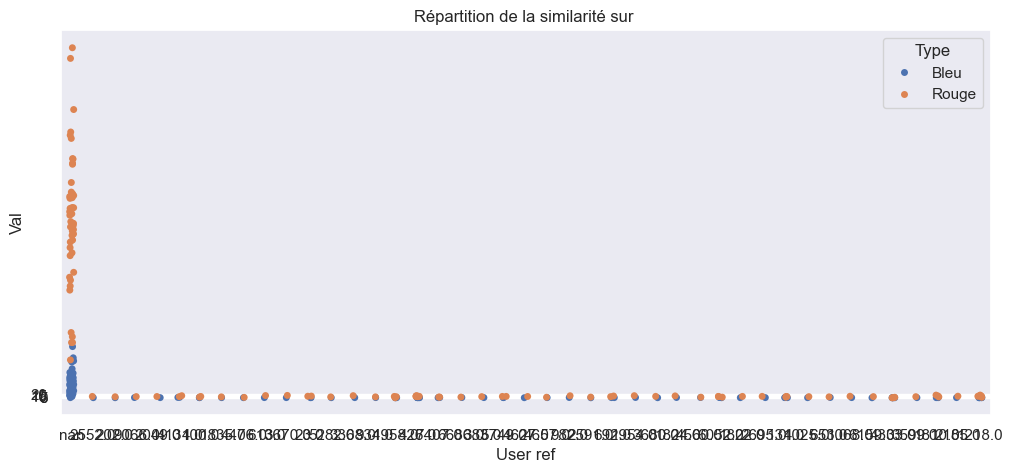

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User ref", y="Val",hue="Type")
plt.yticks(ticks=range(0,25,5),labels=range(0,25,5))
plt.title("Répartition de la similarité sur ")

In [ ]:
# problème de normalisation -> taille des commentaires
# Regarder répartition avec les joueurs aléatoires : voir si y a moins d'overlap qu'avec les joueurs proches
# Si c'est un peu le mm truc, c'est chiant
# doc = commentaire (tf-idf)









# Filtrer les jeux notés par user_ind
user_games = filtered_centrd_data[filtered_centrd_data["User id"] == user_ind]["Game id"].unique()

# Exclure les notes du user_ind -> garder uniquement les voisins !!!!!
df_filtered = neighbours_avis[neighbours_avis["User id"] != user_ind]
# Calculer la moyenne des notes pour chaque jeu
game_avg_ratings = df_filtered.groupby("Game id")["Rating"].mean().reset_index()

# Garder uniquement les jeux que user_ind a notés
df_result = game_avg_ratings[game_avg_ratings["Game id"].isin(user_games)]
# Renommer la colonne moyenne des notes
df_result = df_result.rename(columns={"Rating": "Mean Rating"})
df_result.sort_values('Mean Rating', ascending=False,inplace=True)

best_game = df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"]
print(int(best_game))
df_result.head(10)

# Il faut filtrer avec l'avis sur le jeu de base

KeyError: 'Column not found: Rating'

In [ ]:
from nltk.translate import bleu_score
from sacrebleu import sentence_bleu
from rouge import Rouge

neighbours_avis = neighbours_avis[neighbours_avis['Game id'] == best_game][['User id','Game id']]
#df = ft.get_bleu_rouge(best_game,user_ind,assoc,neighbours,neighbours_avis)
print(neighbours_avis['User id'].to_numpy())
print(user_ind)
ref_avis = neighbours_avis[neighbours_avis['User id'] == user_ind].index[0]
br = neighbours_avis.copy(True)
br = br[br['User id'] != user_ind].reset_index()
br.drop('Game id', axis = 1, inplace=True)
br.columns = ['Avis id', 'User id']
br.sort_values('Avis id', ascending=True)

lem = pd.read_csv('generated_data/avis_lemmatized.csv',index_col=0)
#lem_n = lem[np.isin(lem.index, br['Avis id'].to_numpy())]
br = br.merge(lem,left_on='Avis id', right_index=True, how="inner") # merge left on right_index = True, left_on avis id
#br['Lemma'] = lem_n['Comment'].to_numpy()
ref_lem = lem.loc[ref_avis,'Comment']

blue_scorer = BLEU()
rouge_scorer = Rouge()

br['Bleu'] = br['Comment'].apply(lambda x : blue_scorer.sentence_score(hypothesis=x,references=[ref_lem]).score/100)
#br['Bleu nltk'] = br['Comment'].apply(lambda x : bleu_score.sentence_bleu(hypothesis=[list(x)],references=ref_lem))
br['Rouge'] = br['Comment'].apply(lambda x : rouge_scorer.get_scores(hyps=x,refs=ref_lem)[0]["rouge-l"]["f"])
br['User ref'] = [user_ind]*br.shape[0]
br['Game rec'] = [best_game]*br.shape[0]
br = br[['User ref', 'Game rec', 'Avis id', 'User id', 'Comment', 'Bleu', 'Rouge']]

#bleu_rouge = pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")])

[2289 4735]
2289


It is recommended to enable `effective_order` for sentence-level BLEU.
C:\Users\arlyc\AppData\Local\Temp\ipykernel_25732\836748375.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")])


,User ref,Game rec,Avis id,User id,Comment,Type,Val
0,2289,1077,33809,4735,bluff enfumage retournement situation voici je...,Bleu,0.000345
1,2289,1077,33809,4735,bluff enfumage retournement situation voici je...,Rouge,0.058824
